In [77]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
import tensorflow_datasets as tfds
import torch
from transformers import BertTokenizer, BertForQuestionAnswering

from model import Seq2Seq, BertSeq2Seq
from run import read_examples, convert_examples_to_features

import rdflib

### Implement Question Answering Model

In [78]:
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

In [50]:
# ds = tfds.load('squad/v2.0')
print(ds)
df_train = tfds.as_dataframe(ds['train'])
print(df_train.head(1))
df_test = tfds.as_dataframe(ds['validation'])
print(df_train.head(1))

{'train': <PrefetchDataset shapes: {answers: {answer_start: (None,), text: (None,)}, context: (), id: (), is_impossible: (), plausible_answers: {answer_start: (None,), text: (None,)}, question: (), title: ()}, types: {answers: {answer_start: tf.int32, text: tf.string}, context: tf.string, id: tf.string, is_impossible: tf.bool, plausible_answers: {answer_start: tf.int32, text: tf.string}, question: tf.string, title: tf.string}>, 'validation': <PrefetchDataset shapes: {answers: {answer_start: (None,), text: (None,)}, context: (), id: (), is_impossible: (), plausible_answers: {answer_start: (None,), text: (None,)}, question: (), title: ()}, types: {answers: {answer_start: tf.int32, text: tf.string}, context: tf.string, id: tf.string, is_impossible: tf.bool, plausible_answers: {answer_start: tf.int32, text: tf.string}, question: tf.string, title: tf.string}>}
  answers/answer_start                              answers/text  \
0                   []                                        []

In [57]:
print(len(df_train))

130319


In [66]:
# I was unable to figure out how to do the whole list
question_list_train = df_train['question'].astype(str).tolist()[0]
answers_list_train = df_train['answers/text'].astype(str).tolist()[0]
input_ids = tokenizer.encode(question_list_train, answers_list_train, truncation=True)
print("The inputs has a total of {:} tokens".format(len(input_ids)))

The inputs has a total of 17 tokens


In [67]:
tokens = tokenizer.convert_ids_to_tokens(input_ids)
for token, id in zip(tokens, input_ids):
    if id == tokenizer.sep_token_id:
        print('')
    print('{:<12} {:>6}'.format(token, id)) 
    if id == tokenizer.sep_token_id:
        print('')

[CLS]           101
b              1038
'              1005
what           2054
is             2003
the            1996
danger         5473
of             1997
zinc          15813
after          2044
injury         4544
?              1029
'              1005

[SEP]           102

[              1031
]              1033

[SEP]           102



In [75]:
sep_index = input_ids.index(tokenizer.sep_token_id)
num_seg_a = sep_index + 1
num_seg_b = len(input_ids) - num_seg_a
segment_ids = [0]*num_seg_a + [1]*num_seg_b


In [85]:
result = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([segment_ids]))
start_scores = result.start_logits
end_scores = result.end_logits

answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)
answer = ' '.join(tokens[answer_start:answer_end+1])
print("Answer: " + answer)

Answer: zinc after injury


### Task 2: Unanswerable question detection
propose a model to detect those unanswerable questions, e.g., binaryclassification

The model I propose would work by translating the context into RDF (resource description framework). this is a web standard representation language used to represent semantic information. it can be used to construct knowledge graphs that are open to the web. RDF has a query language called SPARQL, towards which the question could be translated via a method similar to the popular Text2SQL. This scheme is well suited to answer generation and is similar in some ways to the answer generation performed by services like alexa or wolfram alpha which rely on knowledge bases (although as far as I know their knowledge bases are likely not in RDF). However, depending on the translation scheme the linked-open-data (LOD) nature of RDF makes unanswerable question detection a design consideration of the model. The injection of outside knowledge not present in the context will disrupt the model's ability to gauge whether the question can be answered from the information present. Some methods of translation to rdf and sparql which rely on an encoder-decoder scheme trained on human-made examples will inject outside knowledge. For example, [this](https://github.com/YueLiu/NeuralTripleTranslation) library implements an algorithm they call Seq2RDF. Unfortunately I was unable to get their code to function. 

However some, like 

In [45]:
doc0 = df.loc[0, 'context']
print(doc0)
question0 = df.loc[0, 'question']
# answer0 = df.loc[0, 'plausible_answers']['text']
print(question0)
print(df.loc[0, 'is_impossible'])

doc1 = df.loc[3, 'context']
print(doc1)
question1 = df.loc[3, 'question']
# answer1 = df.loc[3, 'plausible_answers'][0]
print(question)
print(df.loc[3, 'is_impossible'])

b"Zinc is included in most single tablet over-the-counter daily vitamin and mineral supplements. Preparations include zinc oxide, zinc acetate, and zinc gluconate. It is believed to possess antioxidant properties, which may protect against accelerated aging of the skin and muscles of the body; studies differ as to its effectiveness. Zinc also helps speed up the healing process after an injury. It is also suspected of being beneficial to the body's immune system. Indeed, zinc deficiency may have effects on virtually all parts of the human immune system."
b'What is the danger of zinc after injury?'
True
b"The coronation of Charlemagne as emperor on Christmas Day 800 is regarded as a turning point in medieval history, marking a return of the Western Roman Empire, since the new emperor ruled over much of the area previously controlled by the western emperors. It also marks a change in Charlemagne's relationship with the Byzantine Empire, as the assumption of the imperial title by the Carol

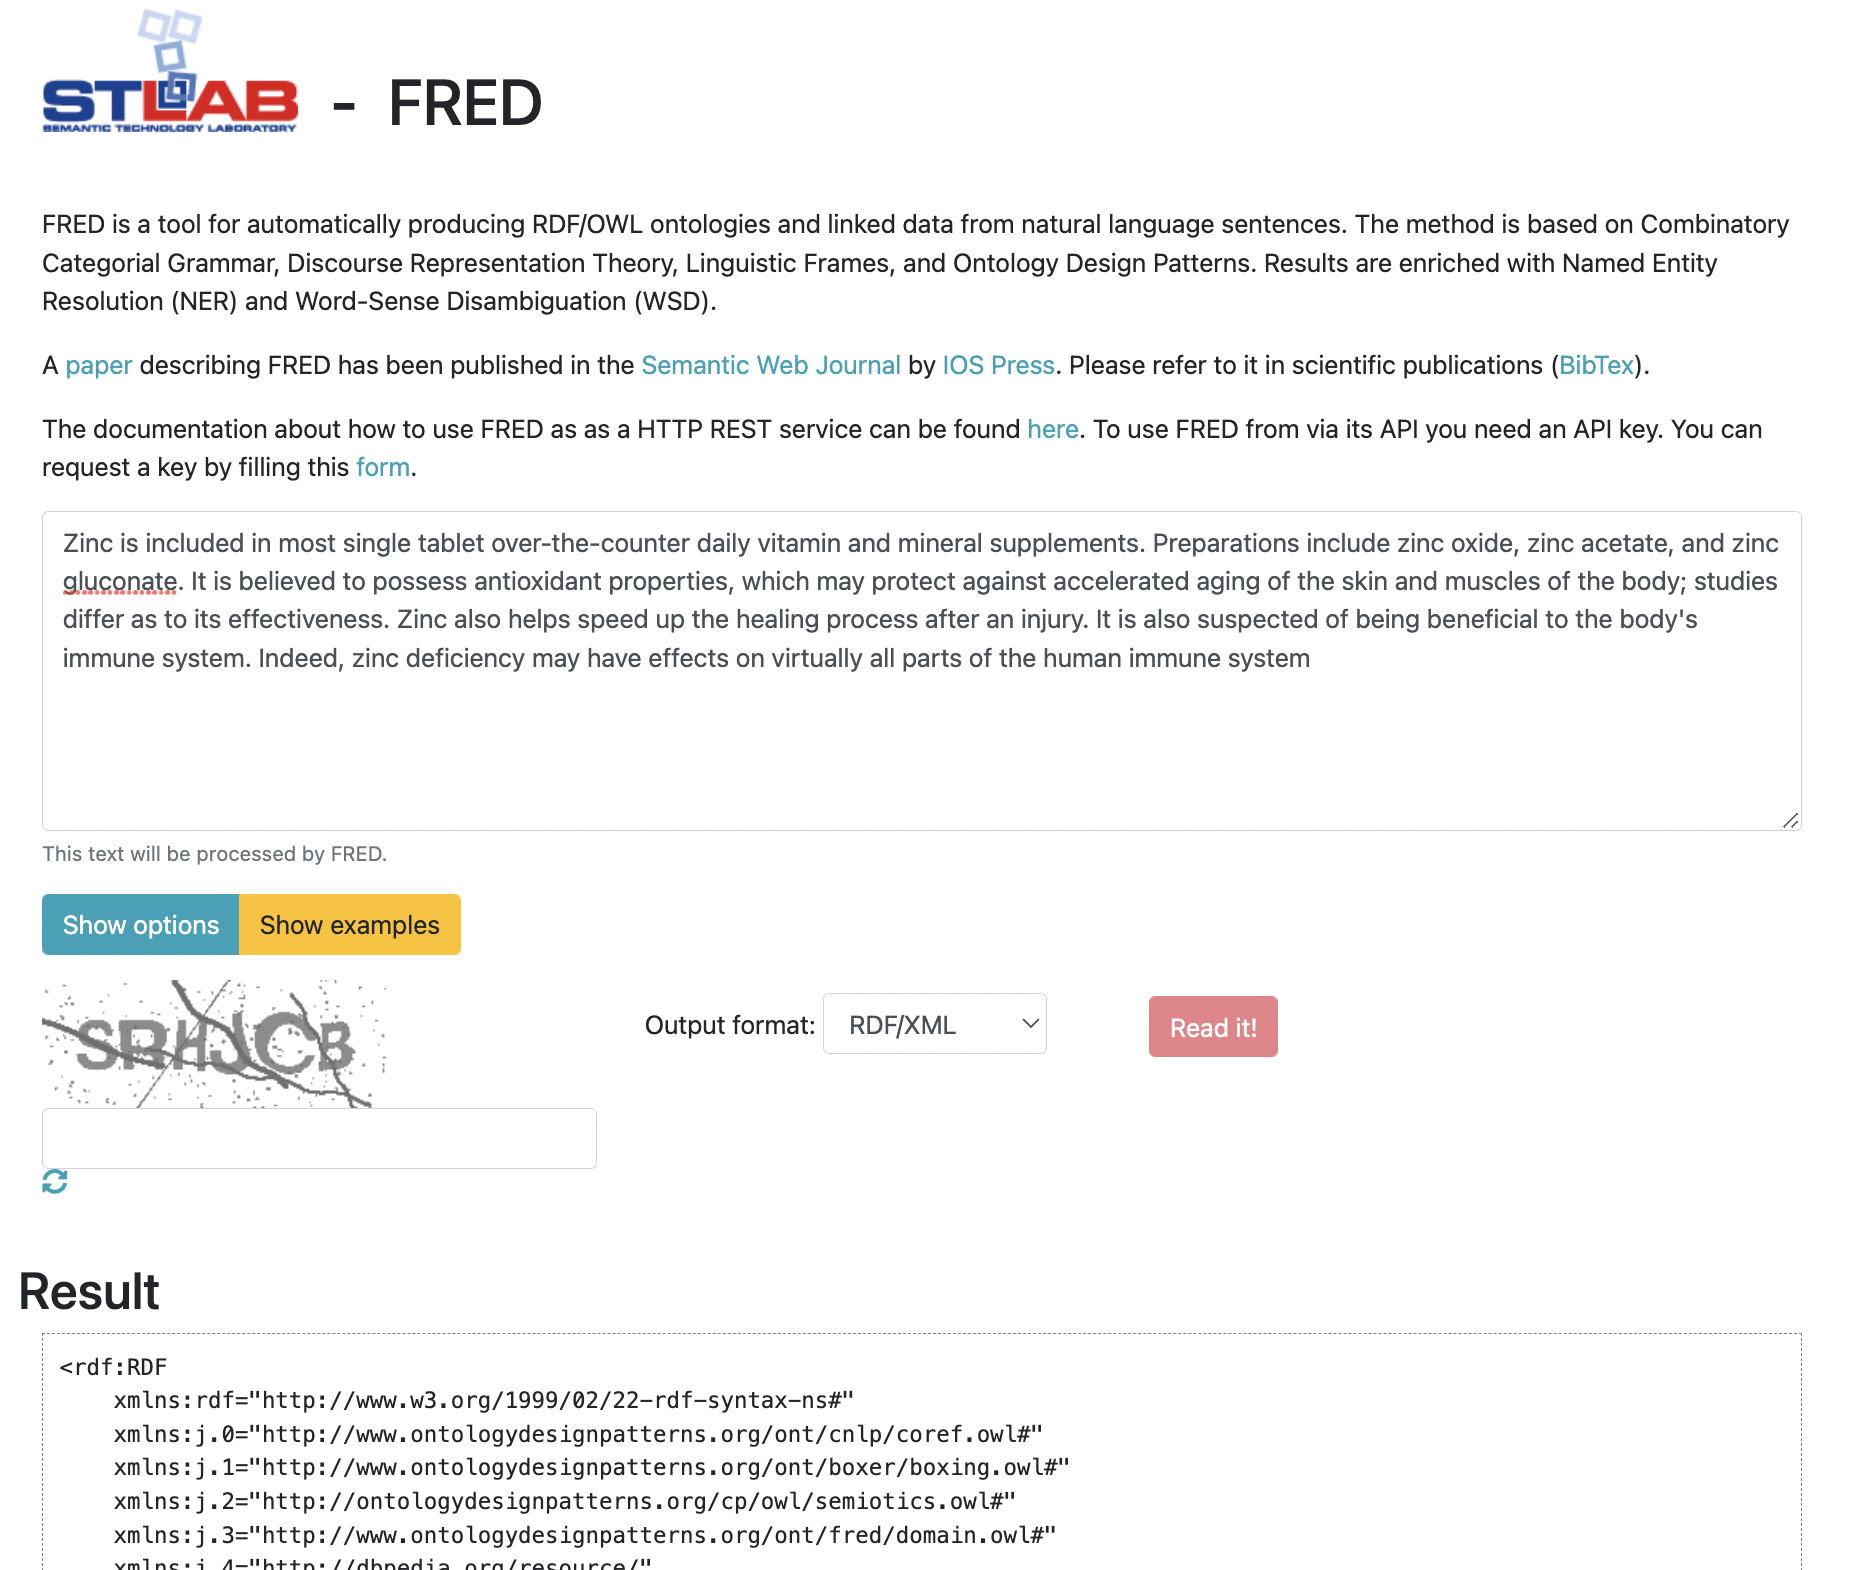

In [7]:
graph0 = rdflib.Graph()
graph0.parse("./doc0.rdf")

graph1 = rdflib.Graph()
graph1.parse("./doc1.rdf")

all_query = """
SELECT ?s ?p ?o
WHERE {
    ?s ?p ?o
}"""

qres = graph0.query(all_query)
for row in qres:
    print(f"{row.s} {row.p} {row.o}")

http://www.ontologydesignpatterns.org/ont/fred/domain.owl#offset_116_120_zinc http://ontologydesignpatterns.org/cp/owl/semiotics.owl#denotes http://www.ontologydesignpatterns.org/ont/fred/domain.owl#zinc_3
http://www.ontologydesignpatterns.org/ont/fred/domain.owl#offset_416_418_of http://www.essepuntato.it/2008/12/earmark#refersTo http://www.ontologydesignpatterns.org/ont/fred/domain.owl#docuverse
http://www.ontologydesignpatterns.org/ont/fred/domain.owl#offset_8_16_included http://ontologydesignpatterns.org/cp/owl/semiotics.owl#denotes http://www.ontologydesignpatterns.org/ont/fred/domain.owl#include_1
http://www.ontologydesignpatterns.org/ont/fred/domain.owl#deficiency_1 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.ontologydesignpatterns.org/ont/fred/domain.owl#ZincDeficiency
http://www.ontologydesignpatterns.org/ont/fred/domain.owl#offset_349_354_speed http://www.ontologydesignpatterns.org/ont/fred/pos.owl#pennpos http://www.ontologydesignpatterns.org/ont/fred/pos.owl#

In [15]:
with open('./NLP2SPARQL_Model.pkl', 'rb') as file_pi:
    model = pickle.load(file_pi)

In [31]:
examples = read_examples("./example_questions.lang", "./example_questions.sparql")
tokenizer = BertTokenizer.from_pretrained("deepset/bert-base-cased-squad2")
args = None
features = convert_examples_to_features(examples, tokenizer, args)
source_ids = torch.tensor([f.source_ids for f in features], dtype=torch.long)
source_mask = torch.tensor([f.source_mask for f in features], dtype=torch.long)

preds = model(source_ids=source_ids, source_mask=source_mask)
p=[]
for pred in preds:
    t = pred[0].cpu().numpy()
    t = list(t)
    if 0 in t:
        t = t[:t.index(0)]
    text = tokenizer.decode(t, clean_up_tokenization_spaces=False)
    p.append(text)

ValueError: not enough values to unpack (expected 2, got 1)